# Homework 5 - Bonus question

Here we will compute the sentiment coming from the email per country. 

In [55]:
## Importation of useful libraries
import pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import operator
import networkx as nx
%matplotlib inline

<h3>Data loading and cleaning</h3>

We will first load the data, and then clean them. We decided to use the "ExtractedBodyText" for this part, therefore we will drop all the empty cells.

In [3]:
filename = os.path.join('hillary-clinton-emails','Emails.csv')
df_email = pd.read_csv(filename)
df_email = df_email.dropna(axis=0, how='any', subset=['ExtractedBodyText'])
df_email.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


 To clean the data, we use exactly the same technique as in exercice 1. Therefore, we decided to export this technique to an external function, and just use the function. All the explanations can be found in exercice 1 of the homework. This function will return a map between the indices of the email dataframe and a list of token (coming from the email of the indice)

In [4]:
## Cleaning data with the external script.
## map : (mail index -> list of tokens)
from cleaningData import getTokenMapFromData
map_mail_index_to_token_list = getTokenMapFromData(False)

Starting to import data
Starting cleaning...
Creating tokens...
list token len= 6742
list index len= 6742
Finished!


In [5]:
print('-- Dataframe: ')
print(df_email.ExtractedBodyText[1])
print('-- Token list : ')
print(map_mail_index_to_token_list[1])

-- Dataframe: 
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
-- Token list : 
['B6', 'H', 'Latest', 'How', 'Syria', 'aiding', 'Qaddafi', '', 'Sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'March', '3', '2011', 'For', 'Hillary']


Importing receiver data

In [45]:
## Import receiver data
receiver_filename = os.path.join('hillary-clinton-emails','EmailReceivers.csv')
receiverdf = pd.read_csv(receiver_filename)
receiverdf.head(2)

,Id,EmailId,PersonId
0,1,1,80
1,2,2,80


We will make a map between the id of an email and its sender.

In [8]:
email_senders_map = {}

def makeEmailSendersMap(row):
    senderId = row.SenderPersonId
    if not np.isnan(senderId):
        email_senders_map[row.Id] = int(senderId)

In [50]:
df_email.apply(makeEmailSendersMap, axis=1)
email_senders_map[3]

32

<h3>Communication graph</h3>

Now, let's create iteratively the first graph of the receivers and senders.

In [52]:
sendReceiveGraph = nx.Graph()

def createGraphWithReceivers(row):
    email_id = row.EmailId
    receiver_id = row.PersonId
    if email_id and receiver_id and email_senders_map.get(email_id):
        sendReceiveGraph.add_edge(email_senders_map[email_id], receiver_id, {'email_id':email_id})

We will apply the method to all the receiver and complete therefore the graph sendReceiveGraph.

In [53]:
receiverdf.apply(createGraphWithReceivers, axis=1)
print('Graph creation finished.')

Graph creation finished.


Let's take a look at the first vertices by degree order.

In [57]:
sorted(sendReceiveGraph.degree_iter(),key=itemgetter(1),reverse=True)[:5]

[(80, 307), (81, 69), (32, 66), (87, 40), (105, 21)]

Now we can plot the graph of all the vertices, increasing the size of a vertice depending on its degree.

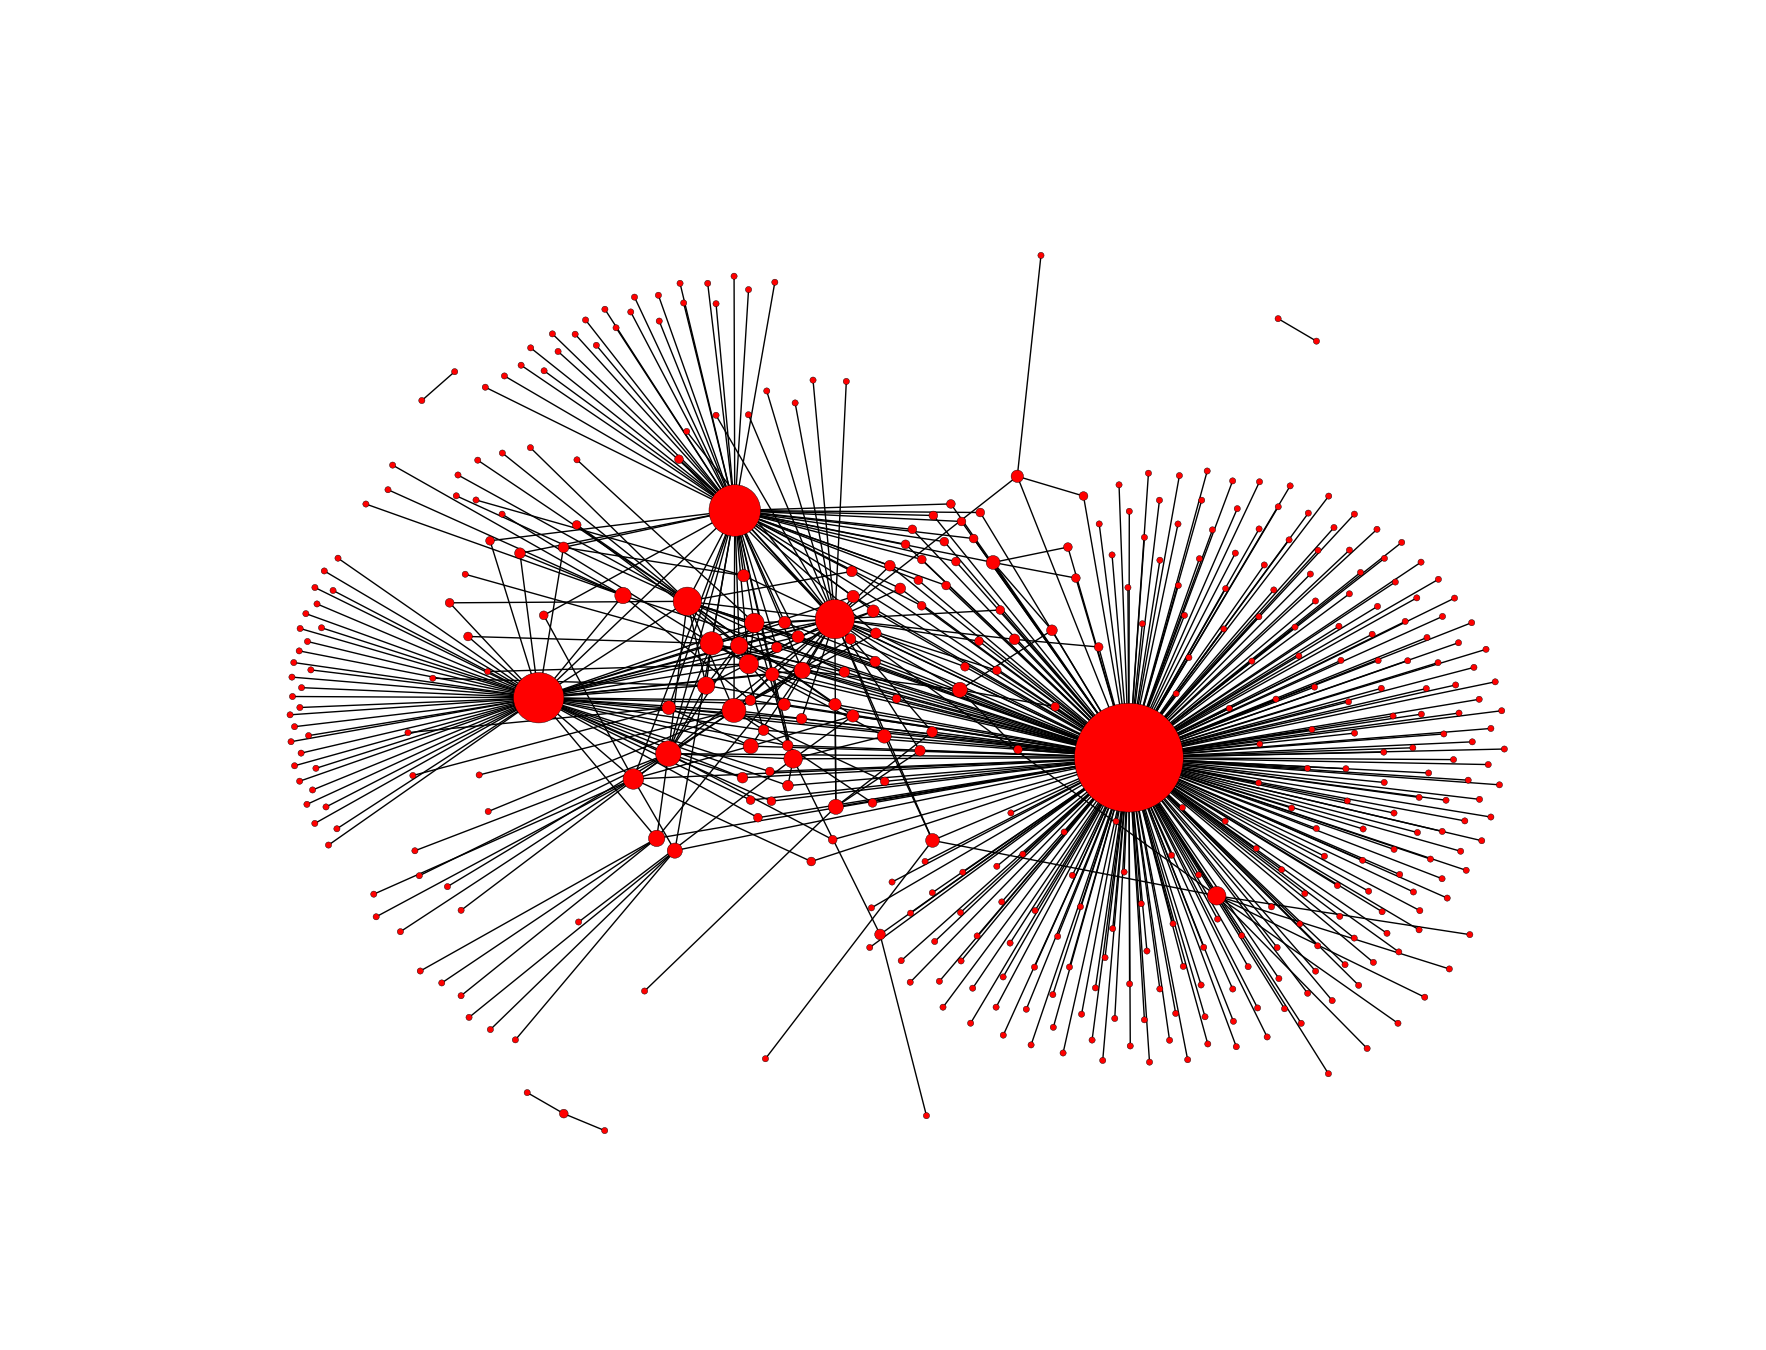

In [59]:
d = nx.degree(sendReceiveGraph)
plt.figure(figsize=(17,13))
nx.draw(sendReceiveGraph, nodelist=d.keys(), node_size=[v * 20 for v in d.values()])

<h3>Best partition</h3>

In [38]:
import community
partition = community.best_partition(sendReceiveGraph)

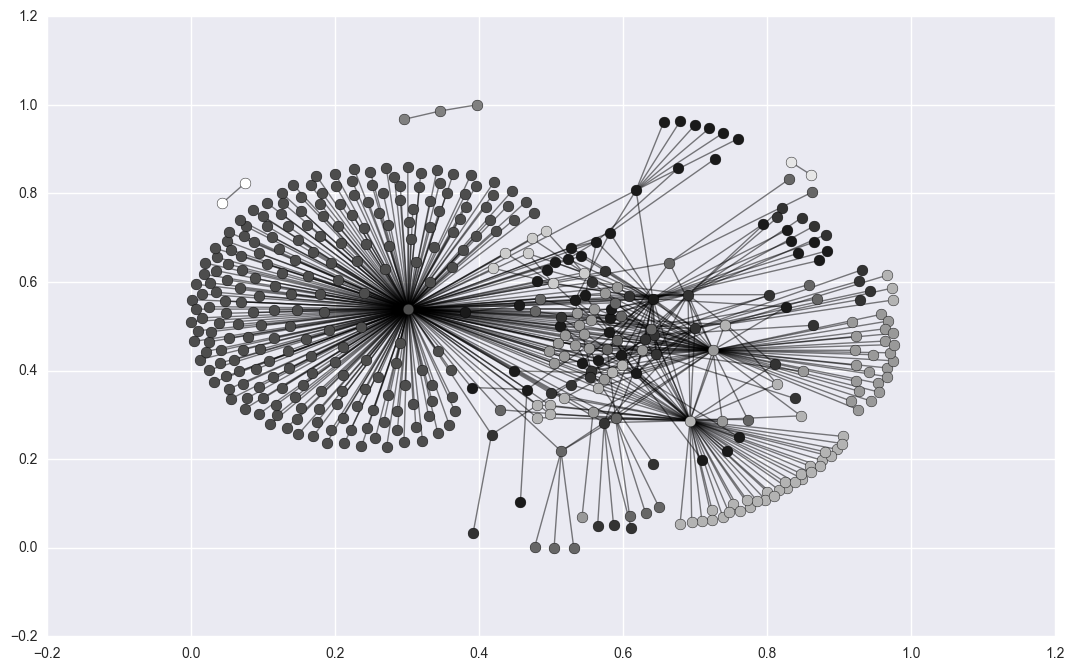

In [39]:
plt.figure(figsize=(13,8))
size = float(len(set(partition.values())))
pos = nx.spring_layout(sendReceiveGraph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(sendReceiveGraph, pos, list_nodes, node_size = 60,
                                node_color = str(count / size))


nx.draw_networkx_edges(sendReceiveGraph,pos, alpha=0.5)
plt.show()

In [40]:
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [32]:
partitionMailMap = {}  ## map between: {partition id -> { token -> occurence}}

for i in range(0,len(set(partition.values()))):
    partitionMailMap[i] = {}

def addMailWordsToPartition(row):
    senderId = row.SenderPersonId
    if not np.isnan(senderId):
        partitionNum = partition[senderId]
        tokenlist = map_mail_index_to_token_list[row.name] #### ! IN CASE OF tokenlistmap ! 
        for token in tokenlist:
            if partitionMailMap[partitionNum].get(token):
                partitionMailMap[partitionNum][token] += 1
            else:
                partitionMailMap[partitionNum][token] = 0

In [33]:
def getMostUsedWordsOfDictionary(token_dict):
    '''
    Input: Dictionary : {token -> occurence}
    Output: List[token_1, token_2, ..., token_20] with occurence(token_i) > occurence(token_j) for i > j
    '''
    return heapq.nlargest(20, token_dict, key=token_dict.get)

In [35]:
print('We will have', len(set(partition.values())), 'communities.')
for partition_id in partitionMailMap:
    print('Community', partition_id,':')
    most_used_words_list = getMostUsedWordsOfDictionary(partitionMailMap[partition_id])
    print(most_used_words_list)
#     for word in most_used_words_list:
#         print(word)

We will have 10 communities.
Community 0 :
[]
Community 1 :
[]
Community 2 :
[]
Community 3 :
[]
Community 4 :
[]
Community 5 :
[]
Community 6 :
[]
Community 7 :
[]
Community 8 :
[]
Community 9 :
[]


# Testing

In [42]:
aa = {1: {'aa':2, 'bb': 3, 'cc': 1}, 2: {'bb': 5}}
aa[1]
import heapq
heapq.nlargest(3, aa[1], key=aa[1].get)

['bb', 'aa', 'cc']

In [ ]:
df_email_initial.RawText[0]
# stem_tokens[1]

In [ ]:
import networkx as nx


In [ ]:

G=nx.Graph()
# G.add_node(0)
# G.add_node(1)
G.add_edge('nice', 'hello', emailId=2)
G.add_edges_from([(2,3,{'color':'green'}), (3,4)])

In [ ]:

pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G,'state')
nx.draw(G, pos)
nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)